In [1]:
import numpy as np
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Generate training data

In [2]:
data = [
    np.random.normal((5.,8.), (0.5,0.5), (25, 2)),
    np.random.normal((-5.,8.), (0.5,0.5), (15, 2)),
    np.random.normal((-10.,0.), (0.4,0.4), (20, 2)),
    np.random.normal((-5.,-8.), (0.4,0.4), (25, 2)),
    np.random.normal((5.,-8.), (0.5,0.5), (10, 2)),
    np.random.normal((10.,0.), (1.0,1.0), (5, 2)),
    ]
data_cat = np.concatenate(data, axis=0)

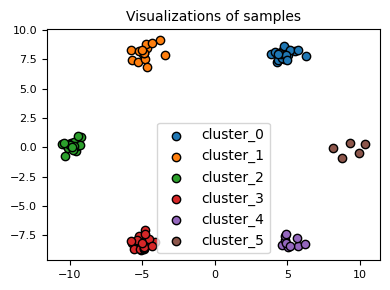

In [3]:
for i, cluster in enumerate(data):
    plt.scatter(data[i][:, 0], data[i][:, 1], edgecolors='black', label=f'cluster_{i}')
plt.legend()
plt.title('Visualizations of samples', fontdict={'fontsize':10})
plt.tight_layout()
plt.show()

# Define density estimation models

* $p_\mathrm{kNN}(x;X) = \frac{k}{N \cdot V_d \cdot R_k(x;X)^d}$

* $p_\mathrm{KDE}(x;X) = \frac{1}{N}\sum_{n=1}^{N} K_{\sigma}(x - x_n)$

* $p_\mathrm{GMM}(x;X) = \sum_{k=1}^{K} \frac{N_k}{N} \mathcal{N}(x; \mu_k, \sigma^2_k \mathbf{I}_{D})$

In [4]:
def knn(x, k, data):
    x = np.array(x)
    data_cat = np.concatenate(data, axis=0)
    dist = np.sort(np.sqrt(np.sum((x[np.newaxis] - data_cat)**2, axis=1)))
    dist_k = dist[k-1]
    prob = k / (len(data_cat) * 4 * np.pi * (dist_k**2))
    return prob

def kde(x, data):
    x = np.array(x)
    data_cat = np.concatenate(data, axis=0)
    dist = np.sqrt(np.sum((x[np.newaxis] - data_cat)**2, axis=1))
    prob = np.exp(-0.5 * dist**2) / np.sqrt(2 * np.pi)
    prob = np.mean(prob, axis=0)
    return prob

def gmm(x, data):
    x = np.array(x)
    data_cat = np.concatenate(data, axis=0)
    means = [np.mean(cluster, axis=0) for cluster in data]
    stds = [np.std(cluster, axis=0) for cluster in data]
    num_samples = [len(cluster) for cluster in data]
    prob = 0.
    for mean, std, num_sample in zip(means, stds, num_samples):
        dist_sq = np.sum((x[np.newaxis] - mean)**2, axis=1)
        prob += np.exp(-0.5 * dist_sq) / np.sqrt(2 * np.pi) * (num_sample/len(data_cat))
    return prob

# Compute estimated likelihood

In [5]:
grid = np.linspace(-15, 15, 30)
xv, yv = np.meshgrid(grid, grid)
    
def compute_ll(method):
    result = np.zeros((len(grid), len(grid)))
    for i in range(len(grid)):
        for j in range(len(grid)):
            result[i][j] = method((grid[i], grid[j]), data=data)
    result = np.array(result)
    return result

prob_knn_5 = compute_ll(partial(knn, k=5))
prob_knn_10 = compute_ll(partial(knn, k=10))
prob_knn_30 = compute_ll(partial(knn, k=30))
prob_kde = compute_ll(kde)
prob_gmm = compute_ll(gmm)

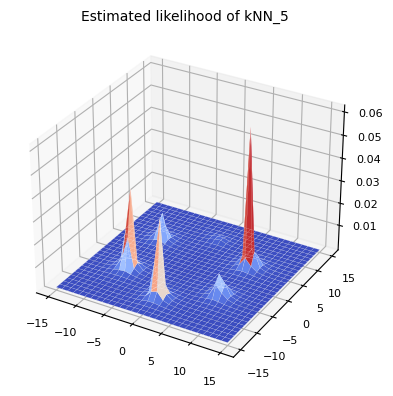

<Figure size 400x300 with 0 Axes>

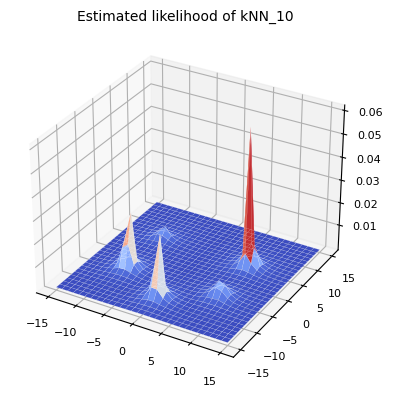

<Figure size 400x300 with 0 Axes>

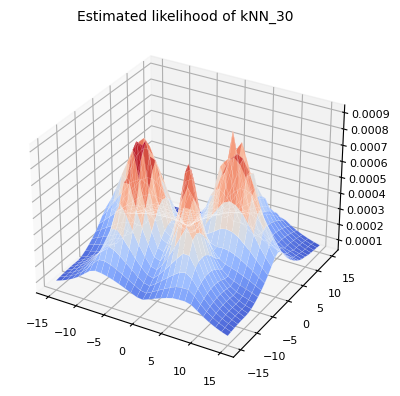

<Figure size 400x300 with 0 Axes>

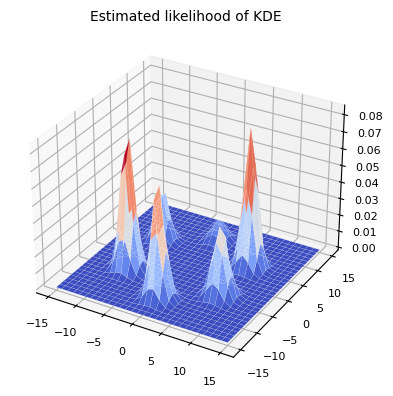

<Figure size 400x300 with 0 Axes>

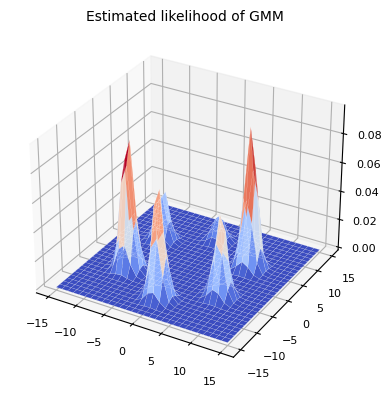

<Figure size 400x300 with 0 Axes>

In [6]:
def visualize(prob, name):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(xv, yv, prob, cmap='coolwarm', rstride=1, cstride=1)
    ax.plot_wireframe(xv, yv, prob, color='white', linewidth=0.1, rstride=1, cstride=1)
    ax.set_title(f'Estimated likelihood of {name}', fontsize=10)
    plt.tight_layout()
    plt.savefig(f'./figs/ll/{name}.png')
    plt.show()
    plt.clf()

visualize(prob_knn_5, 'kNN_5')    
visualize(prob_knn_10, 'kNN_10')
visualize(prob_knn_30, 'kNN_30')
visualize(prob_kde, 'KDE')
visualize(prob_gmm, 'GMM')

# Define Leave-one-out (LOO) training for Influence Function (IF)

In [7]:
def influence_function(x, z, k, data, method):
    data_loo = [cluster[cluster[:,0] != x[0]] for cluster in data]
    if method==knn:
        orig_log_prob = np.log(method(z, k, data))
        loo_log_prob = np.log(method(z, k, data_loo))
    else:
        orig_log_prob = np.log(method(z, data))
        loo_log_prob = np.log(method(z, data_loo))
    return orig_log_prob - loo_log_prob

# Compute Self-Influence for training data

In [8]:
def compute_self_if(method, k=10):
    result = []
    for i in range(len(data_cat)):
        result.append(influence_function(data_cat[i], data_cat[i], k, data, method))
    result = np.array(result)
    return result

self_if_knn_5 = compute_self_if(knn, 5)
self_if_knn_10 = compute_self_if(knn, 10)
self_if_knn_30 = compute_self_if(knn, 30)
self_if_kde = compute_self_if(kde)
self_if_gmm = compute_self_if(gmm)

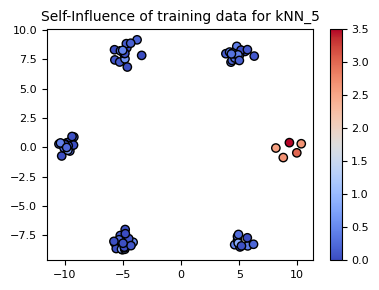

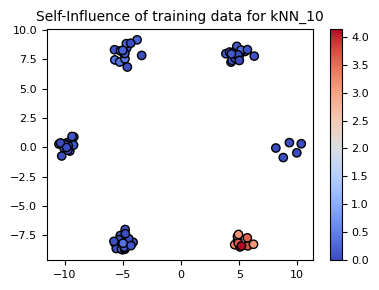

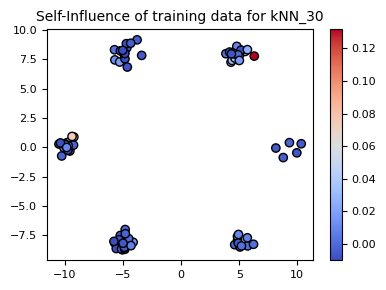

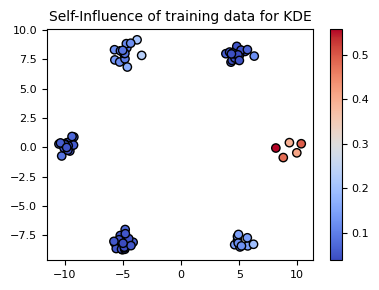

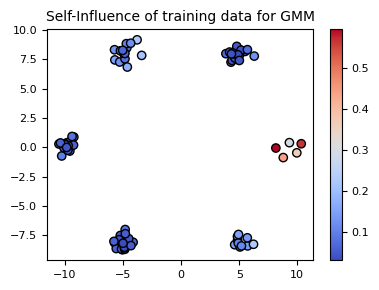

In [9]:
def visualize(prob, name):
    cm = plt.cm.get_cmap('coolwarm')
    sc = plt.scatter(data_cat[:,0], data_cat[:,1], c=prob, vmin=np.min(prob), vmax=np.max(prob), cmap=cm, edgecolors='black')
    plt.colorbar(sc)
    plt.title(f'Self-Influence of training data for {name}', fontsize=10)
    plt.tight_layout()
    plt.savefig(f'./figs/self_if/{name}.png')
    plt.show()

visualize(self_if_knn_5, 'kNN_5')    
visualize(self_if_knn_10, 'kNN_10')
visualize(self_if_knn_30, 'kNN_30')
visualize(self_if_kde, 'KDE')
visualize(self_if_gmm, 'GMM')

In [10]:
z = (5., 8.)

def compute_fixed_if(method, z, k=10):
    result = []
    for i in range(len(data_cat)):
        result.append(influence_function(data_cat[i], z, k, data, method))
    result = np.array(result)
    return result

fixed_if_knn_5 = compute_fixed_if(knn, z, 5)
fixed_if_knn_10 = compute_fixed_if(knn, z, 10)
fixed_if_knn_30 = compute_fixed_if(knn, z, 30)
fixed_if_kde = compute_fixed_if(kde, z)
fixed_if_gmm = compute_fixed_if(gmm, z)

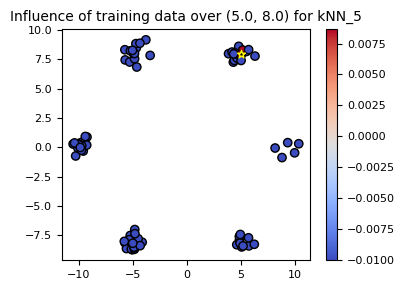

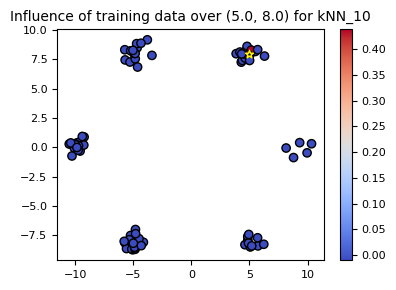

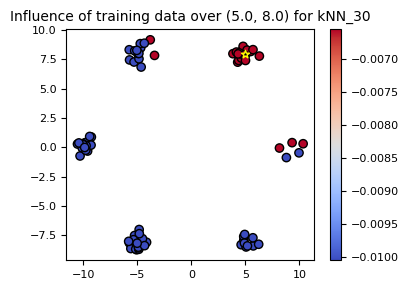

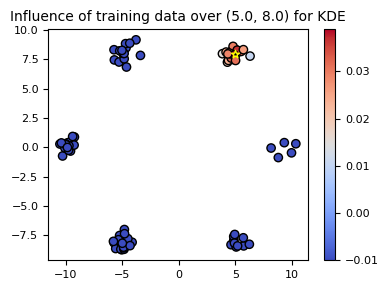

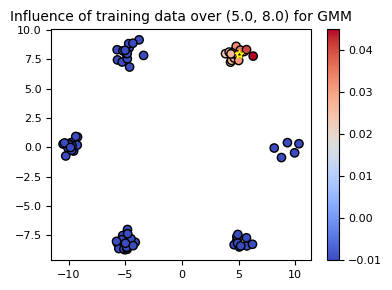

In [11]:
def visualize(prob, name):
    cm = plt.cm.get_cmap('coolwarm')
    sc = plt.scatter(data_cat[:,0], data_cat[:,1], c=prob, vmin=np.min(prob), vmax=np.max(prob), cmap=cm, edgecolors='black')
    plt.colorbar(sc)
    plt.scatter(z[0], z[1], c='black', edgecolors='yellow', marker='*')
    plt.title(f'Influence of training data over {z} for {name}', fontsize=10)
    plt.tight_layout()
    plt.savefig(f'./figs/if/{name}.png')
    plt.show()

visualize(fixed_if_knn_5, 'kNN_5')    
visualize(fixed_if_knn_10, 'kNN_10')
visualize(fixed_if_knn_30, 'kNN_30')
visualize(fixed_if_kde, 'KDE')
visualize(fixed_if_gmm, 'GMM')